In [8]:
using Plots
using Distributions
using Random
using Interpolations

# car parameters
mass=1500.0 #kg
power=80e3 #W
brake_acceleration=8.0 #m/s^2
Cd=0.4 # drag coefficient
A=2.0 # frontal area
min_speed=0.5 #m/s
cost_per_J=1.85/(45e6)#$/J
cost_pers_s=40/(60*60)#$/s
red_crossed_penalty=50.0 #$
max_acceleration(v)=min(10.0,power/(v+min_speed))

rho=1.2 # air density
time_to_green_distribution=Exponential(3.0)
initial_speed=30.0 #m/s
initial_position=-150.0 #m
location_discretization=50
speed_discretization=100
time_discretization=100
speedup_discretization=1000
acceleration_discretization=100
locations=range(initial_position, stop=0.0, length=location_discretization)
dx=locations[2]-locations[1]
speeds=range(min_speed, stop=initial_speed, length=speed_discretization)
max_time=quantile(time_to_green_distribution,0.99)+2.5*abs(initial_position)/initial_speed
times=range(0.0, stop=max_time, length=time_discretization)

accelerations=zeros(location_discretization,time_discretization, speed_discretization)
function compute_power(acceleration::Float64,v)
    drag_force=0.5*rho*Cd*A*v^2
    acceleration_force=max(0,acceleration)*mass
    return (drag_force+acceleration_force)*v
end

loss(time_loss::Real, energy_loss::Real)=time_loss*cost_pers_s+energy_loss*cost_per_J

function compute_speedup_losses()
    x=0.0
    t=0.0
    energy=0.0
    speeds=range(min_speed,stop=initial_speed,length=speedup_discretization)
    energy_loss_speedup=zeros(length(speeds))
    time_loss_speedup=zeros(length(speeds))
    dv=(initial_speed-min_speed)/(speedup_discretization-1)
    for i in eachindex(speeds)
        v=speeds[i]
        a=max_acceleration(v)
        dt=dv/a
        x+=v*dt
        t+=dt
        energy+=compute_power(a,v)*dt
        energy_loss_speedup[i]=energy-compute_power(0.0,initial_speed)/initial_speed*x
        time_loss_speedup[i]=t-x/initial_speed
    end
    final_energy_loss=energy_loss_speedup[end]
    final_time_loss=time_loss_speedup[end]
    energy_loss_speedup=final_energy_loss .- energy_loss_speedup
    time_loss_speedup=final_time_loss .- time_loss_speedup
    loss_speedup=loss.(time_loss_speedup, energy_loss_speedup)
    return Interpolations.LinearInterpolation(speeds, loss_speedup, extrapolation_bc=Flat())
end
speedup_losses=compute_speedup_losses()

dloss(v::Real, a::Real, dt::Real)=loss(dt*(initial_speed-v)/initial_speed, compute_power(a,v)*dt)+dt*pdf()

tail_losses=linear_interpolation((times,speeds),[speedup_losses(v)+red_crossed_penalty for t in times, v in speeds], extrapolation_bc=Flat())

for i in location_discretization:-1:1
    x=locations[i]
    next_tail_loss_matrix=zeros(time_discretization, speed_discretization)
    for (t_index,t) in enumerate(times)
        for (v_index,v) in enumerate(speeds)
            a = range(-brake_acceleration, stop=max_acceleration(v), length=acceleration_discretization)
            dt=dx/v
            next_v=v .+ a .* dt
            tail_loss=[tail_losses(t+dt,v+a*dt) for a in a]
            p_turns_green=pdf.(time_to_green_distribution, t) ./ (1 .- cdf(time_to_green_distribution,t)) *dt
            losses=tail_loss .* (1 .- p_turns_green) .+ p_turns_green .* speedup_losses(v)
            losses[next_v .< min_speed] .= Inf
            losses[next_v .> initial_speed] .= Inf
            min_loss_index=argmin(losses)
            accelerations[i,t_index,v_index]=a[min_loss_index]
            next_tail_loss_matrix[t_index,v_index]=losses[min_loss_index]
        end
    end
    tail_losses=linear_interpolation((times,speeds),next_tail_loss_matrix, extrapolation_bc=Flat())
end

accelerations_interpolation=linear_interpolation((locations,times,speeds),accelerations, extrapolation_bc=Flat())



50×100×100 extrapolate(scale(interpolate(::Array{Float64, 3}, BSpline(Linear())), (-150.0:3.061224489795918:0.0, 0.0:0.26581323795923506:26.315510557964274, 0.5:0.29797979797979796:30.0)), Flat()) with element type Float64:
[:, :, 1] =
 0.0          0.0          0.0          …  0.0          0.0
 0.181818     0.181818     0.181818        0.181818     0.181818
 8.07435e-17  8.07435e-17  8.07435e-17     8.07435e-17  8.07435e-17
 0.181818     0.181818     0.181818        0.181818     0.181818
 1.61487e-16  1.61487e-16  1.61487e-16     1.61487e-16  1.61487e-16
 0.181818     0.181818     0.181818     …  0.181818     0.181818
 1.61487e-16  1.61487e-16  1.61487e-16     1.61487e-16  1.61487e-16
 0.181818     0.181818     0.181818        0.181818     0.181818
 3.22974e-16  3.22974e-16  3.22974e-16     3.22974e-16  3.22974e-16
 0.181818     0.181818     0.181818        0.181818     0.181818
 ⋮                                      ⋱               
 4.72727      4.72727      4.72727         4.72727

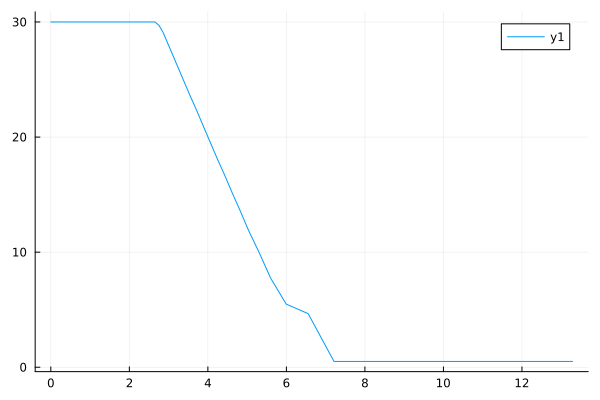

In [10]:
# compute path
function compute_trajectory(initial_speed::Real)
    speeds=zeros(location_discretization)
    times=zeros(location_discretization)
    speeds[1]=initial_speed
    for i in 2:location_discretization
        v=speeds[i-1]
        dt=dx/v
        a=accelerations_interpolation(locations[i],dt,v)
        speeds[i]=v+a*dt
        times[i]=times[i-1]+dt
    end
    return speeds,times
end
v,t=compute_trajectory(initial_speed)
using Plots
plot(t,v) |> display